In [4]:
PATH='/home/kirana/Documents/phd/exp3_autoencoder'
DATAPATH='/home/kirana/Documents/final_dissertation_final/experiments/datasets/ml-latest-small'

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import os
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

In [6]:
[df, df_train,df_valid,df,df_ratings,dfflagtrain,dfflagvalid,idx_to_user,\
             idx_to_movie,movie_to_idx,user_to_idx]=pickle.load(open(f'{DATAPATH}/reads.pkl','rb'))

In [11]:
df.shape

(100836, 19)

In [9]:
df.head()

,userId,movieId,rating,timestamp,title,genres,imdbId,tmdbId,tag,random_dstype,seqNum,maxSeqNum,time_dstype,user_idx,movie_idx,dstype_random_train,dstype_time_train,dstype_random_valid,dstype_time_valid
0,1,1210,5.0,2000-07-30 18:08:19,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi,86190,1892.0,NaN,train,1,232,train,1,1,1,1,0,0
1,1,804,4.0,2000-07-30 18:08:19,She's the One (1996),Comedy|Romance,117628,11363.0,NaN,train,2,232,train,1,2,1,1,0,0
2,1,2628,4.0,2000-07-30 18:08:43,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Sci-Fi,120915,1893.0,NaN,train,3,232,train,1,3,1,1,0,0
3,1,2826,4.0,2000-07-30 18:08:43,"13th Warrior, The (1999)",Action|Adventure|Fantasy,120657,1911.0,NaN,train,4,232,train,1,4,1,1,0,0
4,1,2018,5.0,2000-07-30 18:08:43,Bambi (1942),Animation|Children|Drama,34492,3170.0,NaN,test,5,232,train,1,5,0,1,1,0


In [64]:
df_train=df.loc[df['random_dstype']=='train']
df_valid=df.loc[df['random_dstype']!='train']

In [79]:
df_train.head()

,userId,movieId,rating,timestamp,title,genres,imdbId,tmdbId,tag,random_dstype,seqNum,maxSeqNum,time_dstype,user_idx,movie_idx,dstype_random_train,dstype_time_train,dstype_random_valid,dstype_time_valid
0,1,1210,5.0,2000-07-30 18:08:19,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi,86190,1892.0,NaN,train,1,232,train,1,1,1,1,0,0
1,1,804,4.0,2000-07-30 18:08:19,She's the One (1996),Comedy|Romance,117628,11363.0,NaN,train,2,232,train,1,2,1,1,0,0
2,1,2628,4.0,2000-07-30 18:08:43,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Sci-Fi,120915,1893.0,NaN,train,3,232,train,1,3,1,1,0,0
3,1,2826,4.0,2000-07-30 18:08:43,"13th Warrior, The (1999)",Action|Adventure|Fantasy,120657,1911.0,NaN,train,4,232,train,1,4,1,1,0,0
5,1,3578,5.0,2000-07-30 18:11:08,Gladiator (2000),Action|Adventure|Drama,172495,98.0,NaN,train,6,232,train,1,6,1,1,0,0


### Dataset and DataLoader

In [16]:
class cfdata (torch.utils.data.dataset.Dataset):
    def __init__(self,dfX,dfY):
        self.dfX,self.dfY=dfX,dfY
        
    def __len__ (self):
        return self.dfX.shape[0]
    
    def __getitem__ (self, idx):
        return torch.LongTensor(self.dfX.iloc[idx].values),torch.FloatTensor([self.dfY.values[idx]])

In [80]:
dstrain=cfdata(df_train[['user_idx','movie_idx']],df_train['rating'])
dsvalid=cfdata(df_valid[['user_idx','movie_idx']],df_valid['rating'])

In [81]:
df_train.shape

(90752, 19)

In [82]:
bs=8

In [83]:
dltrain=DataLoader(dstrain,bs,True)

In [84]:
dlvalid=DataLoader(dsvalid,bs,True)

## Model Architecture

In [85]:
n_users=len(user_to_idx)
n_movies=len(movie_to_idx)
n_emb_user=10
n_emb_movie=25
min_rating=min(df_train['rating'])
max_rating=max(df_train['rating'])
dropout_e=0.05
hidden=[25,10]
dropouts=[0.2,0.2]

In [86]:
def hidden_layer(x,y,dropout,activation=nn.Sigmoid()):
    return nn.Sequential(
        nn.Linear(x, y),
        activation,
        nn.Dropout(p=dropout)
        )   

In [122]:
class cf(nn.Module):    
    def __init__(self,n_users,n_emb_user,n_emb_movie,n_movies,min_rating,max_rating,\
                 dropout_e=0.01,hidden=[25,10],dropouts=[0.2,0.2]):
        super().__init__()
        self.n_users,self.n_emb_user,self.n_emb_movie,self.n_movies,self.min_rating,self.max_rating=\
                    n_users,n_emb_user,n_emb_movie,n_movies,min_rating,max_rating
        self.dropout_e,self.hidden,self.dropouts=dropout_e,hidden,dropouts
        self.create_architecture()
        self.criterion=nn.MSELoss()
        
        
    def create_architecture(self):
        self.emb_user=nn.Embedding(self.n_users+1,self.n_emb_user)
        self.emb_movie=nn.Embedding(self.n_movies+1,self.n_emb_movie)
        self.emb_dropout=nn.Dropout(self.dropout_e)
        
        lins=[hidden_layer(self.n_emb_user+self.n_emb_movie if i==0 else self.hidden[i-1],\
                                self.hidden[i] if i <len(hidden) else 1,
                                self.dropouts[i] if i < len(hidden) else 0,
                                nn.ReLU()) for i in range(len(hidden)+1)]
        self.lins=nn.Sequential(*lins)
        self.sigmoid=nn.Sigmoid()
        
        
    def init_parameters(self):
        nn.init.kaiming_normal_(self.emb_user.weight.data)
        nn.init.kaiming_normal_(self.emb_movie.weight.dat)
        #nn.init.kaiming_normal_(lin)
       
    def forward (self,Xb,Yb):
        #import pdb
        #pdb.set_trace()
        users=self.emb_dropout(self.emb_user(Xb[:,0]))
        items=self.emb_dropout(self.emb_movie(Xb[:,1]))
        embed=torch.cat([users,items],1)
        out=self.lins(embed)
        out=self.sigmoid(out)
        preds=out*(self.max_rating-self.min_rating)+self.min_rating
        #preds=preds.view(-1)
        loss=self.criterion(preds,Yb)
        return preds,loss

In [123]:
cfobj=cf(n_users,n_emb_user,n_emb_movie,n_movies,min_rating,max_rating,dropout_e,hidden,dropouts)

In [124]:
cfobj

cf(
  (emb_user): Embedding(611, 10)
  (emb_movie): Embedding(9725, 25)
  (emb_dropout): Dropout(p=0.05)
  (lins): Sequential(
    (0): Sequential(
      (0): Linear(in_features=35, out_features=25, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=25, out_features=10, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=10, out_features=1, bias=True)
      (1): ReLU()
      (2): Dropout(p=0)
    )
  )
  (sigmoid): Sigmoid()
  (criterion): MSELoss()
)

In [125]:
for Xb, Yb in dltrain:
    break

In [126]:
Xb.shape, Yb.shape

(torch.Size([8, 2]), torch.Size([8, 1]))

In [127]:
cfobj.forward(Xb,Yb)

(tensor([[2.7500],
         [2.7500],
         [2.7500],
         [2.7500],
         [2.7500],
         [2.7500],
         [2.8581],
         [2.7500]], grad_fn=<AddBackward0>),
 tensor(1.8342, grad_fn=<MseLossBackward>))

## Learner

In [165]:
class Learner():
    def __init__(self,model,optimizer,metric_fn,device,bptt=12,print_every=5,clip_val=None,\
                 cycle_mult=0,lr_decay=0.7,wd_mult=6,start_lr=2e-2, end_lr=5e-4):
        self.model,self.optimizer,self.metric_fn,self.device,self.print_every,self.bptt,self.losses,self.clip_val=\
            model,optimizer,metric_fn,device,print_every,bptt,[],clip_val
        self.n_epochs=1
        self.cycle_mult,self.lr_decay=cycle_mult,lr_decay
        self.wd_mult=wd_mult
        for param_group in self.optimizer.param_groups:
            self.start_lr=param_group['lr']
            self.start_wd=param_group['weight_decay']
        self.wd=self.start_wd
        self.lr=self.start_lr
        self.end_lr=end_lr
        self.n_epoch=0
        self.lrs=[1e-2,5e-3,1e-4,5e-4]
        self.preds,self.preds_valid,self.trainY,self.actual=[],[],[],[]
        self.ratio=self.end_lr/self.start_lr
        self.num_steps=self.cycle_mult
        self.reset_cycle=self.cycle_mult
        
    def fit (self,Xb,Yb,mode_train=True):
        if mode_train:
            self.model.train()
        else:
            self.model.eval()
        
        #import pdb
        #pdb.set_trace()
        preds,loss=self.model(Xb,Yb)

        with torch.no_grad():
            if self.metric_fn is not None:
                acc=self.metric_fn(preds,Yb.view(-1),self.device)
                acc=acc.item()

                if 1==0:
                    if mode_train:
                        self.trainY.append(Yb.view(-1))
                        self.preds.append(preds.data)
                    else:
                        self.actual.append(Yb.view(-1))
                        self.preds_valid.append(preds.data)
            else:
                acc=0
            del preds
        
        if mode_train:
            if 1==0:
                lr =self.lrs[torch.randint(0,4,(1,))]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        myloss=loss.item()
        acc=np.sqrt(myloss)
        del loss
        
        if self.clip_val is not None:
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_val)
        
        return myloss, acc
    
    def lr_find (self,start_lr,end_lr,iterator,n_batch):
        losses,lrs=[],[]
        ratio=end_lr/start_lr
        num_steps=n_batch
        lr=start_lr
        for i in range(num_steps):            
            lr=lr*(end_lr/start_lr)**(1/num_steps)
            lrs.append(lr)
        self.lrs=lrs
        self.run_epoch(iterator,mode_train=True,lrs=lrs)
    
    def run_epoch(self,iterator,mode_train,lrs=None):
        epoch_loss,epoch_acc,i,k=0,0,0,0

        for Xb,Yb in iterator:
            Xb=Xb.to(self.device)
            Yb=Yb.to(self.device)
            
            if lrs is not None:
                lr=lrs[k]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr 
            

            loss,acc=self.fit(Xb,Yb,mode_train)
            
            if lrs is not None:
                self.losses.append(loss)
            
            
            epoch_loss+=loss
            epoch_acc+=acc
            
            k=k+1
            if k%self.print_every == 0:
                if k:
                    print (f'Batch:{k} {epoch_loss/(k)}  ')  
                    torch.cuda.empty_cache()
        epoch_loss=epoch_loss/len(iterator)
        epoch_acc=epoch_acc/len(iterator)
            
        return epoch_loss,epoch_acc
    
    def plot_lrs(self, n_roll=1,ylim=None,xlim=None):
        import seaborn as sns
        ax=sns.lineplot(x=self.lrs,y=pd.Series(self.losses).rolling(n_roll).mean())
        ax.set_xscale('log')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate')
        if ylim is not None:
            plt.ylim(ylim)
        if xlim is not None:
            plt.xlim(xlim)

     
    def run_epochs(self,dltrain,dlvalid,n_epochs=1):              
        for epoch in range(n_epochs):                
            loss,acc=self.run_epoch(dltrain,True)
            lossv,accv=self.run_epoch(dlvalid,mode_train=False)
            print (f'Epoch:{epoch} Learning rate {self.lr} Weight Decay {self.wd} Train Loss:{loss} \
                Valid Loss:{lossv} Train RMSE:{acc} Valid RMSE:{accv}')
  
            if self.cycle_mult:
                if self.n_epoch==self.reset_cycle:
                    self.lr=self.start_lr
                    #self.wd=self.start_wd
                    self.reset_cycle*=self.cycle_mult
                    #reset_cycle=self.n_epoch+reset_cycle
                    self.n_epoch=0
                    self.ratio=self.end_lr/self.start_lr
                    self.num_steps=self.reset_cycle
                else:
                    #self.lr*=(self.lr_decay**self.n_epoch)  
                    #if self.n_epoch>1:
                    #    self.wd*=self.wd_mult
                    self.lr=self.lr*(self.end_lr/self.start_lr)**(1/self.num_steps)
                    self.n_epoch+=1
        

                
            for param_group in self.optimizer.param_groups:
                param_group['lr']=self.lr
                #param_group['weight_decay']=self.wd
          
     

In [140]:
device='cuda:1'

In [132]:
cfobj=cf(n_users,n_emb_user,n_emb_movie,n_movies,min_rating,max_rating,dropout_e,hidden,dropouts)

In [133]:
cfobj=cfobj.to(device)

In [134]:
cfobj

cf(
  (emb_user): Embedding(611, 10)
  (emb_movie): Embedding(9725, 25)
  (emb_dropout): Dropout(p=0.05)
  (lins): Sequential(
    (0): Sequential(
      (0): Linear(in_features=35, out_features=25, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=25, out_features=10, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=10, out_features=1, bias=True)
      (1): ReLU()
      (2): Dropout(p=0)
    )
  )
  (sigmoid): Sigmoid()
  (criterion): MSELoss()
)

In [144]:
wd=1e-7
optimizer=torch.optim.Adam(cfobj.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(cfobj,optimizer,None,device,0,1000,0.25,cycle_mult=0)

In [146]:
len(dltrain)

11344

In [145]:
learner.lr_find(1e-4,1e-1,dltrain,len(dltrain))

Batch:1000 1.2871376111581923  
Batch:2000 1.1871284601427614  
Batch:3000 1.160463286705315  
Batch:4000 1.1334724818188697  
Batch:5000 1.111314104191959  
Batch:6000 1.091881392877549  
Batch:7000 1.0685967387078064  
Batch:8000 1.0524587289607152  
Batch:9000 1.0439664796450072  
Batch:10000 1.0468855257101357  
Batch:11000 1.0551408863575622  


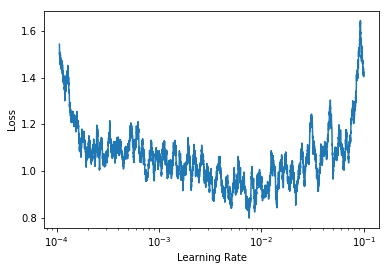

In [150]:
learner.plot_lrs(100)

In [151]:
wd=1e-7
optimizer=torch.optim.Adam(cfobj.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(cfobj,optimizer,None,device,0,12000,0.25,cycle_mult=0)

In [153]:
learner.run_epochs(dltrain,dlvalid,10)

Epoch:0 Learning rate 0.005 Weight Decay 1e-07 Train Loss:1.000516924380531  Valid Loss:0.9905012431041198 
Epoch:1 Learning rate 0.005 Weight Decay 1e-07 Train Loss:0.9278076135806939  Valid Loss:0.8942036906539401 
Epoch:2 Learning rate 0.005 Weight Decay 1e-07 Train Loss:0.8613234448653209  Valid Loss:0.8934999079363012 
Epoch:3 Learning rate 0.005 Weight Decay 1e-07 Train Loss:0.8442755302986359  Valid Loss:0.8966075777889337 
Epoch:4 Learning rate 0.005 Weight Decay 1e-07 Train Loss:0.8352935271493943  Valid Loss:0.9017556234514732 
Epoch:5 Learning rate 0.005 Weight Decay 1e-07 Train Loss:0.8254447352708933  Valid Loss:0.8799727800450657 
Epoch:6 Learning rate 0.005 Weight Decay 1e-07 Train Loss:0.8205997493186682  Valid Loss:0.887499321042357 
Epoch:7 Learning rate 0.005 Weight Decay 1e-07 Train Loss:0.8209300116271014  Valid Loss:0.8793279424569703 
Epoch:8 Learning rate 0.005 Weight Decay 1e-07 Train Loss:0.8163490489608646  Valid Loss:0.8780806550163772 
Epoch:9 Learning rate

In [157]:
del cfobj

NameError: name 'cfobj' is not defined

In [158]:
torch.cuda.empty_cache()

In [159]:
cfobj=cf(n_users,n_emb_user,n_emb_movie,n_movies,min_rating,max_rating,dropout_e,hidden,dropouts)
cfobj=cfobj.to(device)

In [163]:
wd=1e-7
optimizer=torch.optim.Adam(cfobj.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(cfobj,optimizer,None,device,0,12000,0.25,cycle_mult=2,start_lr=8e-3,end_lr=8e-4)

In [164]:
learner.run_epochs(dltrain,dlvalid,10)

Epoch:0 Learning rate 0.005 Weight Decay 1e-07 Train RMSE:0.8229285681844204                 Valid Loss:0.8615894848798401 Train RMSE:0.8698911480072277 Valid RMSE:0.8874446766972895
Epoch:1 Learning rate 0.002 Weight Decay 1e-07 Train RMSE:0.7523871154602544                 Valid Loss:0.8140621552159633 Train RMSE:0.8295780716880736 Valid RMSE:0.8634174622510996
Epoch:2 Learning rate 0.0008 Weight Decay 1e-07 Train RMSE:0.7161900063668613                 Valid Loss:0.8155646758843849 Train RMSE:0.8081958299777826 Valid RMSE:0.8668685153529271
Epoch:3 Learning rate 0.005 Weight Decay 1e-07 Train RMSE:0.764548994610953                 Valid Loss:0.8362634741685676 Train RMSE:0.8370915583281759 Valid RMSE:0.874047153482369
Epoch:4 Learning rate 0.0031622776601683794 Weight Decay 1e-07 Train RMSE:0.7377704635803681                 Valid Loss:0.8137270287447369 Train RMSE:0.821531772251338 Valid RMSE:0.8672721559925182
Epoch:5 Learning rate 0.002 Weight Decay 1e-07 Train RMSE:0.71436568218

In [172]:

torch.save(cfobj,f'{DATAPATH}/inter/cfobj')

/home/kirana/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type cf. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [177]:
torch.save(optimizer,f'{DATAPATH}/inter/optimizer')

In [183]:
pickle.dump(learner,open(f'{DATAPATH}/inter/learner','wb'))

PicklingError: Can't pickle <class '__main__.Learner'>: it's not the same object as __main__.Learner